# Topic 41: Deep Neural Networks

## First: Let's Explore

https://playground.tensorflow.org/


## Tuning Neural Networks

<img src="https://media.giphy.com/media/st83jeYy9L6Bq/giphy.gif">

### AKA - Huge Blocks of Text, For Reference!

### a. Adding nodes and layers

- Number of hidden layers

*For many problems you can start with just one or two hidden layers it will work just fine. For more complex problems, you can gradually ramp up the number of hidden layers until your model starts to over fit. Very complex tasks, like image classification without convolutional layers, will need dozens of layers.* 

- Number of neurons per layer

*The number of neurons for the input and output layers is dependent on your data and the task. i.e. input dimensions are determined by your number or columns and your output layer for binary classification has just one node with a sigmoid activation function. For hidden layers, a common practice is to create a funnel with funnel with fewer and fewer neurons per layer.*

*In general, you will get more bang for your buck by adding on more layers than adding more neurons.*

### b. Activation functions

* One thing important for activation functions is its **differentiability** because the derivative is used in the backpropagation process

<img src='images/activation.png' width=500/>

#### Activation functions for output layers (for supervised learning problems)

1. For binary classification problems: sigmoid activation to coerce values between 0-1
2. For multiclass classification: softmax activation, as it produces a non-negative vector that sums to 1 (probabilities of your test point belonging to the different classes)
3. For regression problems: linear, or relu activation (it is linear and unbounded!)

#### Activation functions for hidden layers

Relevant/useful blog posts (by different authors, despite the similar titles): 
- [Exploring Activation Functions for Neural Networks](https://towardsdatascience.com/exploring-activation-functions-for-neural-networks-73498da59b02)
    - Discusses why adding non-linear activation functions helps us solve non-linear problems, as well as why an understanding of the derivatives of these activation functions helps us tune NNs more effectively
- [Understanding Activation Functions in Neural Networks](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)
    - Builds the intuitition behind activation functions (despite less-than-stellar grammar and punctuation throughout)

Notes: 
* Sigmoids are not used often because it has a small maximum derivative value and thus propagates only a small amount of error each time, leading to slow "learning" 
* This small-derivative-slow-learning issue is known as a **vanishing gradient** problem
* Tanh is mathematically quite similar to a sigmoid function, thus also has the vanishing gradient issue, but not as bad
* ReLu generally works well because its gradient is always 1, as long as the input is positive (no vanishing gradients), and negative inputs going to 0 can make your network lighter (no weights/biases are being updated)

Note - you may want to consider both the [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) and [exploding gradient](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/) problems. And here's a resource on fixing the vanishing gradient problem: https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/

### c. Loss functions

Loss functions are akin to cost functions we were trying to minimize in gradient descent (i.e. RMSE for linear regression, Gini/entropy for trees)

1. For regression problems, keras has **mean_squared_error** or **mean_absolute_error** as a loss function, or **mean_squared_logarithmic_error** if your target has potential outliers
2. For binary classification: **binary_crossentropy** 
3. For multiclass problems: **categorical_crossentropy**

[This article summarizes the above, and more.](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

### d. Optimizers

Overview Resource: 
- [A (Quick) Guide to Neural Network Optimizers with Applications in Keras](https://towardsdatascience.com/a-quick-guide-to-neural-network-optimizers-with-applications-in-keras-e4635dd1cca4) blog post - an overview of the options

Summary:
* Different optimizers are just different methods/paths that your neural network can take to find optimal values
* Experimentally, Adam (derived from *adaptive moment estimation*) is a good one to use ([more about Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/))

#### Quick optimizer summary

* **RMSProp**: maintains per-parameter learning rates adapted based on the average of recent weight updates (e.g. how quickly it is changing). This does well on non-stationary problems (e.g. noisy data)

* **Adagrad**: maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems)

* **Adam**: realizes the benefits of both AdaGrad and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance)

### e. Learning rate

* The learning rate is something you can define when you compile your model with the optimizer
* Optimizers usually change up the learning rates, so this is just the *initial* learning rate
* If you set it too low, training will eventually converge, but it will do so slowly
* If you set it too high, it might actually diverge
* If you set it slightly too high, it will converge at first but miss the local optima

### f. Regularization

* As a neural network learns, neuron weights settle into their context within the network
* Weights of neurons are tuned for specific features providing some specialization
* Neighboring neurons become too reliant on this specialization, which if taken too far can result in a fragile model too specialized to the training data
* This reliance on context for a neuron during training is referred to as *complex co-adaptations*

#### Methods to combat overfitting
1. You can add L1 or L2 regularization within each hidden layer
2. You can also add a **dropout layer** 
3. Not technically *regularization*, but you can introduce **early stopping** so your model doesn't overtrain

#### Dropout
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. You can add **dropout layers** in your neural network.

<img src='images/thanos.png'/>

## Create, then Tune!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

# Note - importing keras straight from tensorflow here
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

#### Explore Data

In [3]:
# Grabbing our data directly from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_train.shape

(60000, 28, 28)

Label: 5


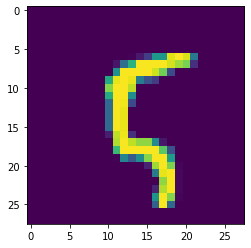

In [7]:
# Explore an example
sample_index = 100

sample_image = X_train[sample_index]
sample_label = y_train[sample_index]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

In [5]:
sample_image.shape

(28, 28)

In [8]:
sample_image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

#### Prep Data

In [9]:
# Normalize our inputs - from https://keras.io/examples/vision/mnist_convnet/
input_shape = (28, 28, 1) # creating this tuple for later

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# Prepare our outputs
num_classes = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
print("y_train shape:", y_train.shape)

y_train shape: (60000, 10)


#### First S***** Model!

In [15]:
# Model building in a single list
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(84, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                65940     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                850       
Total params: 66,790
Trainable params: 66,790
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Defining our training hyperparameters
# Initial values from: https://keras.io/examples/vision/mnist_convnet/
batch_size = 128
epochs = 15

# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 1s 1ms/step - loss: 0.4042 - accuracy: 0.8883 - val_loss: 0.2366 - val_accuracy: 0.9325
Epoch 2/15
469/469 [==============================] - 1s 1ms/step - loss: 0.2117 - accuracy: 0.9396 - val_loss: 0.1789 - val_accuracy: 0.9478
Epoch 3/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1602 - accuracy: 0.9553 - val_loss: 0.1453 - val_accuracy: 0.9572
Epoch 4/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1280 - accuracy: 0.9643 - val_loss: 0.1247 - val_accuracy: 0.9646
Epoch 5/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1067 - accuracy: 0.9706 - val_loss: 0.1118 - val_accuracy: 0.9675
Epoch 6/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0900 - accuracy: 0.9751 - val_loss: 0.1022 - val_accuracy: 0.9705
Epoch 7/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0771 - accuracy: 0.9790 - val_loss: 0.0980 - val_accuracy: 0.9710
Epoch 

In [18]:
# Evaluate!
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08295683562755585
Test accuracy: 0.9746999740600586


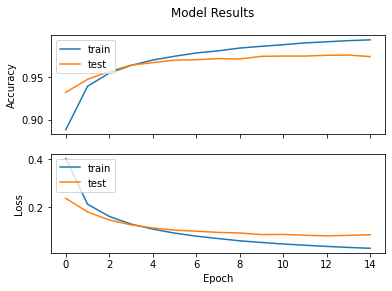

In [19]:
# Visualize results
visualize_training_results(history)

#### Evaluate: 

How'd we do?

- 


What should we do next?

- 


#### Next!

In [20]:
# Model building in a single list
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(84, activation='tanh'),
        layers.Dropout(rate=.1),
        layers.Dense(num_classes, activation='softmax')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)                65940     
_________________________________________________________________
dropout (Dropout)            (None, 84)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                850       
Total params: 66,790
Trainable params: 66,790
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.4187 - accuracy: 0.8834 - val_loss: 0.2484 - val_accuracy: 0.9277
Epoch 2/15
469/469 [==============================] - 1s 1ms/step - loss: 0.2338 - accuracy: 0.9317 - val_loss: 0.1895 - val_accuracy: 0.9447
Epoch 3/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1870 - accuracy: 0.9445 - val_loss: 0.1619 - val_accuracy: 0.9525
Epoch 4/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1570 - accuracy: 0.9540 - val_loss: 0.1369 - val_accuracy: 0.9576
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1371 - accuracy: 0.9596 - val_loss: 0.1210 - val_accuracy: 0.9643
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1205 - accuracy: 0.9644 - val_loss: 0.1090 - val_accuracy: 0.9676
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1073 - accuracy: 0.9681 - val_loss: 0.1059 - val_accuracy: 0.9687
Epoch 

In [23]:
# Evaluate!
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08144126832485199
Test accuracy: 0.9749000072479248


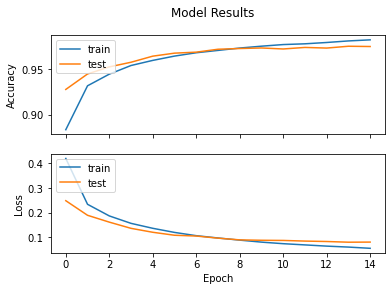

In [24]:
visualize_training_results(history)

In [30]:
# Model building in a single list
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(84, activation='tanh'),
        layers.Dropout(rate=.1),
        layers.Dense(42, activation='tanh'),
        layers.Dropout(rate=.1),        
        layers.Dense(num_classes, activation='softmax')
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 84)                65940     
_________________________________________________________________
dropout_1 (Dropout)          (None, 84)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 42)                3570      
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                430       
Total params: 69,940
Trainable params: 69,940
Non-trainable params: 0
__________________________________________________

In [31]:
# Compiling our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
# Fit our model (save output to a history variable)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.4330 - accuracy: 0.8813 - val_loss: 0.2354 - val_accuracy: 0.9319
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.2286 - accuracy: 0.9327 - val_loss: 0.1749 - val_accuracy: 0.9486
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1793 - accuracy: 0.9473 - val_loss: 0.1467 - val_accuracy: 0.9556
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1509 - accuracy: 0.9560 - val_loss: 0.1244 - val_accuracy: 0.9616
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1301 - accuracy: 0.9606 - val_loss: 0.1117 - val_accuracy: 0.9666
Epoch 6/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1174 - accuracy: 0.9646 - val_loss: 0.1033 - val_accuracy: 0.9682
Epoch 7/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1053 - accuracy: 0.9678 - val_loss: 0.0946 - val_accuracy: 0.9715
Epoch 

In [33]:
# Evaluate!
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08019571006298065
Test accuracy: 0.9761999845504761


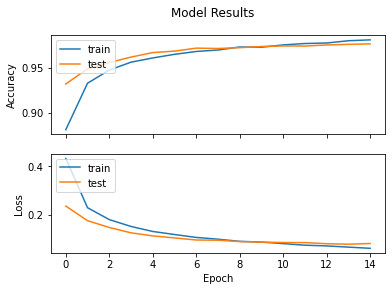

In [34]:
visualize_training_results(history)

Keras tuner for hyperparameters: https://www.tensorflow.org/tutorials/keras/keras_tuner (a tutorial)

## If We Have Time: 

# Building a CNN

## Convolutional Layers

A convolutional neural network is a neural network with **convolutional layers**. CNNs are mainly used for image recognition/classification. They can be used for video analysis, NLP (sentiment analysis, topic modeling), and speech recognition. 

### How do our brains see an image? 

We might see some fluffy tail, a wet nose, flappy ears, and a good boy and conclude we are probably seeing a dog. There is not one singular thing about a dog that our brain recognizes as a dog but an amalgamation of different patterns that allow us to make a probable guess.  

<img src='images/chihuahua.jpeg'/>

### How do computers see images?

<img src='images/architecture.jpeg' width=700/>

To computers, color images are a 3D object - composed of 3 matrices - one for each primary color that can be combined in varying intensities to create different colors. Each element in a matrix represents the location of a pixel and contains a number between 0 and 255 which indicates the intensity of the corresponding primary color in that pixel.

<img src='images/rgb.png'/>

## Convolutions

**To *convolve* means to roll together**. CNNs make use of linear algebra to identify patterns using the pixel values (intensity of R,G, or B). By **taking a small matrix and moving it across an image and multiplying them together every time it moves**, our network can mathematically identify patterns in these images. This small matrix is known as a *kernel* or *filter* and each one is designed to identify a particular pattern in an image (edges, shapes, etc.)

<img src='images/convolve.gif' width=500/>

When a filter is "rolled over" an image, the resulting matrix is called a **feature map** - literally a map of where each pattern of feature is in the image. Elements with higher values indicate the presence of a pattern the filter is looking for. The values (or weights) of the filter are adjusted during back-propagation.

#### Convolutional layer parameters

1. Padding: sometimes it is convenient to pad the input volume with zeros around the border. Helps with detecting patterns at the edge of an image
2. Stride: the number of pixels to shift the filter on each "roll". The larger the stride, the smaller the feature map will be - but we will lose more information


### Pooling Layers

After a convolutional layer, the feature maps are fed into a max pool layer. Like convolutions, this method is applied one patch at a time (usually 2x2). Max pooling simply takes the largest value from one patch of an image, places it in a new matrix next to the max values from other patches, and discards the rest of the information contained in the activation maps. Other methods exist such as average pooling (taking an average of the patch).

<img src='images/maxpool.png'/>

This process results in a new feature map with reduced dimensionality that is then passed into another convolution layer to continue the pattern finding process. These steps are repeated until they are passed to a fully connected layer that proceeds to classify the image using the identified patterns.

### Flattening

Once the neural network has collected a series of patterns that an image contains, it is ready to make a guess as to what the image is. In order to do so, it starts by **flattening** the 2D matrix into a 1D vector, so it can be passed into a normal densely connected layer for classification. Then using this vector, one or many densely connected layers will make a prediction as to what the image is.

In [ ]:
# New dataset!
from keras.datasets import cifar10

# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    
plt.show()
# If you get a "downloading data" thing, worry not, shouldn't take long

In [ ]:
# Checking the class balance of our data
pd.DataFrame(y_train)[0].value_counts()

In [ ]:
# Still need to prep our data
# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (32, 32, 3)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

In [ ]:
# And, prep our outputs
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Model building using "add"
# Model architecture from MLM post linked below
cnn = keras.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2)))

# now, to get the proper output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
cnn.add(layers.Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

In [ ]:
history = cnn.fit(X_train,
                  y_train,
                  epochs=5, # small since this is just a demo
                  batch_size=64,
                  validation_data=(X_test, y_test))
# note - even with just 5 epochs this'll take many minutes

In [ ]:
# Evaluate!
score = cnn.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

A worked-through example on this dataset: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/